In [94]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [95]:
# usando as unidades de medida do SI
C = 100 * 10**-12
G_L, E_L = 10 * 10**-9, -70 * 10**-3
G_Na, E_Na = 3.6 * 10**-6, 55 * 10**-3
G_K, E_K = 1.6 * 10**-6, -90 * 10**-3
G_T, E_Ca = 0.22 * 10**-6, 120 * 10**-3

valor_spike = -0.01 # valor adotado para considerar que ocorreu um potencial de acao
num_spikes = 0 # variavel para armazenar o numero de disparos

In [96]:
def alpham(V):
    if V == (-0.035):
        return 10**3 / np.exp(-100*(V+0.035))
    else:
        return (10**5 * (V+0.035)) / (1 - np.exp(-100*(V+0.035)))
def alphan(V):
    if V == (-0.034):
        return (5 * 10**2) / np.exp(-100*(V+0.034))
    else:
        return (5 * 10**4 * (V+0.034)) / (1 - np.exp(-100*(V+0.034)))

def alphah(V): return 350*np.exp(-50*(V+0.058))

def betam(V): return 4000*np.exp(-(V+0.06)/0.018)
def betan(V): return 625*np.exp(-12.5*(V+0.044))
def betah(V): return 5000 / (1 + np.exp(-100*(V+0.028)))

def m_i(V): return alpham(V) / (alpham(V) + betam(V))
def m_ti(V): return 1 / (1+np.exp(-(V+0.052) / 0.0074))
def h_ti(V): return 1 / (1+np.exp(500*(V+0.076)))

def t_ht(V):
    if V>=(-0.080):
        return 0.028 + 0.001*np.exp(-(V+0.022) / 0.0105)
    else:
        return 0.001*np.exp(15*(V+0.467))

In [97]:
t = np.arange(0, 0.750, 0.00001)    # array com valores de tempo
correntes = np.zeros(shape=(101, 2)) # array com os pares de corrente base e corrente degrau
intervalos_spikes = []

In [98]:
# loop com as correntes degrau e base variando
for i in range(101):
    J_base = (-200+(i*4)) * 10**-12
    J_degrau = (i) * 10**-12
    J_injetada = J_base + J_degrau
    ti_base = 0
    tf_base = 0.250
    ti_degrau = 0.250
    tf_degrau = 0.500
    
    # array com os valores de corrente no tempo
    def J_inj(t):
        return J_base*(t>ti_base)-J_base*(t>tf_base)+J_injetada*(t>ti_degrau)-J_injetada*(t>tf_degrau)+J_base*(t>0.500)


    # equacoes do modelo
    def dALLdt(X,t):
        V, h, n, h_t = X
        dVdt = (J_inj(t) - G_L*(V-E_L) - G_Na * m_i(V)**3 * h*(V-E_Na) - G_K * n**4 * (V-E_K) - G_T * m_ti(V)**2 * h_t*(V-E_Ca)) / C
        dhdt = alphah(V)*(1-h) - betah(V) * h
        dndt = alphan(V)*(1-n) - betan(V) * n
        dh_tdt = (h_ti(V) - h_t) / t_ht(V)

        return dVdt, dhdt, dndt, dh_tdt


    v0, h0, n0, h_t0 = -0.070, 0.89619, -0.06208, 1/(1+np.exp(3))   # valores iniciais
    X = odeint(dALLdt, [v0, h0, n0, h_t0], t) # resolucao das equacoes
    V = X[:,0]
    h = X[:,1]
    n = X[:,2]
    h_t = X[:,3]
    
    # armazenar os pares de corrente base e degrau
    correntes[i][0] = J_base
    correntes[i][1] = J_degrau
    
    # loop para calcular o numero de disparos e o menor intervalo entre eles
    for n in range(len(V)-1):
        if V[n]<valor_spike and V[n+1]>valor_spike:
            num_spikes += 1
            intervalo = t[n+1] - t[n]
            intervalos_spikes.append(intervalo)
            intervalo_minimo = min(intervalos_spikes)
            
    plt.plot()

132
9.99999999995449e-06


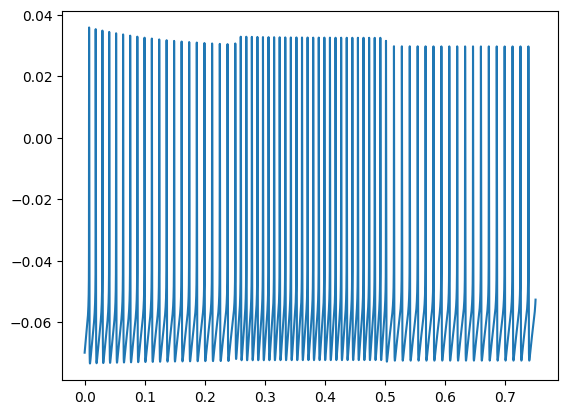

In [100]:

print(num_spikes)
print(intervalo_minimo)

plt.plot(t, V)